# Préambule
___

In [1]:
import pandas as pd

import data_preambule
import strategies
from tool_kit import*

import sys
from joblib import load, Parallel, delayed
from tqdm import tqdm

In [2]:
# parameters
DATA_PATH = '../../data/high_10m.parquet'
NUM_LAGS = 10
NUM_STOCKS = 9000
TRAIN_WINDOW = 50
OUTPUT_PATH = '../../data/processed_high_10m_subset.parquet'
SEED = 42
SHRINKAGE_LIST = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]


In [3]:
sys.argv = [
    'data_preambule.py',
    '--data_path', DATA_PATH,
    '--num_lags', str(NUM_LAGS),
    '--num_random_stocks', str(NUM_STOCKS),
    '--output_path', OUTPUT_PATH,
    '--seed', str(SEED)
]

In [4]:
data_preambule.main()

Loading data...
Creating lag features...
Sampling 9000 random stocks...
Data ready for modeling.
                                all_ex  mid_open  sum_delta    return  \
symbol timestamp                                                        
ARTL   2021-12-01 11:10:00    DZQPYUNK   0.65305  -0.006169 -0.002215   
       2021-12-01 11:20:00         DPK   0.65130  -0.003504 -0.002680   
       2021-12-01 11:30:00      QZPDKU   0.65190  -0.002376  0.000921   
       2021-12-01 11:40:00  DQKZPJYNUV   0.64450   0.019478 -0.011351   
       2021-12-01 11:50:00   VDYUZQKPN   0.64080  -0.057036 -0.005741   

                            return_lag_1  return_lag_2  return_lag_3  \
symbol timestamp                                                       
ARTL   2021-12-01 11:10:00      0.004605      0.018207     -0.008753   
       2021-12-01 11:20:00     -0.002215      0.004605      0.018207   
       2021-12-01 11:30:00     -0.002680     -0.002215      0.004605   
       2021-12-01 11:40:00     

In [6]:
# Define the vector of features
features = [f"return_lag_{i}" for i in range(1, 11)]

# Linear Regression
___

In [4]:
# Load dataset
table2 = pd.read_parquet(OUTPUT_PATH)
table2.head(2)

all_ex  mid_open  sum_delta    return  \
symbol timestamp                                                      
ARTL   2021-12-01 11:10:00  DZQPYUNK   0.65305  -0.006169 -0.002215   
       2021-12-01 11:20:00       DPK   0.65130  -0.003504 -0.002680   

                            return_lag_1  return_lag_2  return_lag_3  \
symbol timestamp                                                       
ARTL   2021-12-01 11:10:00      0.004605      0.018207     -0.008753   
       2021-12-01 11:20:00     -0.002215      0.004605      0.018207   

                            return_lag_4  return_lag_5  return_lag_6  \
symbol timestamp                                                       
ARTL   2021-12-01 11:10:00      0.014937     -0.004851      0.001332   
       2021-12-01 11:20:00     -0.008753      0.014937     -0.004851   

                            return_lag_7  return_lag_8  return_lag_9  \
symbol timestamp                                                       
ARTL   2021-12-01 11:10:00      0.000470     -0.007931      0.006338   
       2021-12-01 11:20:00      0.001332      0.000470     -0.007931   

                            return_lag_10  
symbol timestamp                           
ARTL   2021-12-01 11:10:00       0.000000  
       2021-12-01 11:20:00       0.006338

In [7]:
# Run in parallel
results_nested = Parallel(n_jobs=-1)(
    delayed(run_regression_for_symbol)(
        symbol, group, features=features, train_window=TRAIN_WINDOW
    )
    for symbol, group in tqdm(table2.groupby("symbol"))
)

# Flatten the list of lists
OLS_regression_results = [item for sublist in results_nested for item in sublist]

# Store the results
pd.DataFrame(OLS_regression_results).to_parquet('../../data/OLS_regression_results.parquet', index=False)

100%|██████████| 9000/9000 [24:49<00:00,  6.04it/s]


Loading data...
Running Buy & Hold model...
Buy & Hold - SR: -0.0397
Market timing returns - SR: 0.1384
Long short returns - SR: 0.2430
R2 score: -1.1454


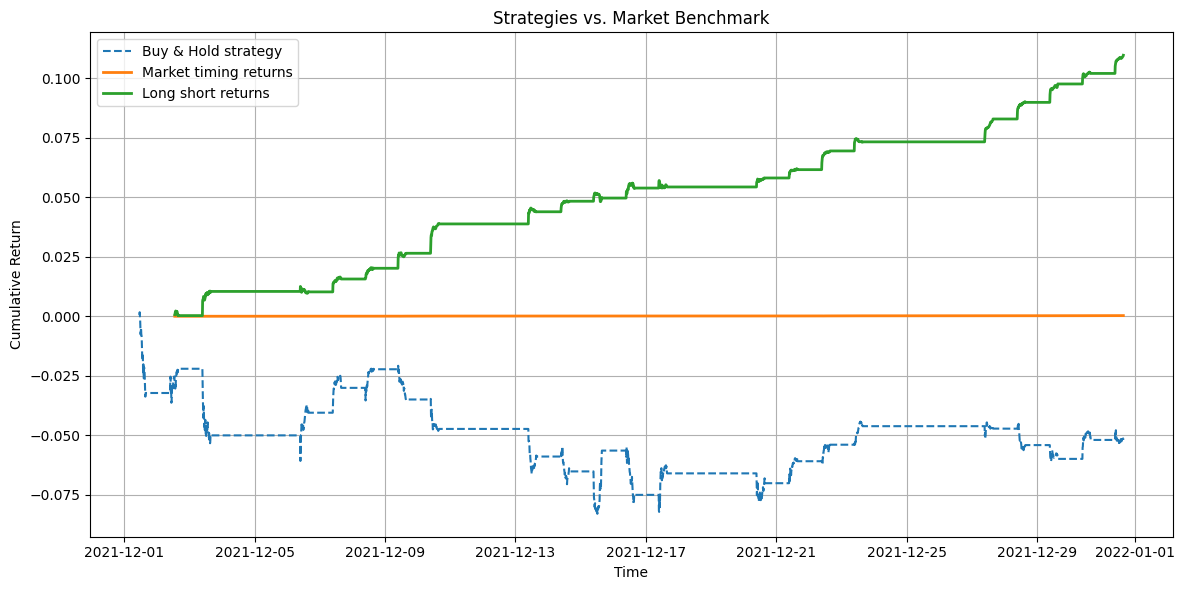

In [8]:
sys.argv = [
    'regressions.py',
    '--data_path', str(OUTPUT_PATH),
    '--model_path', '../../data/',
    '--model', 'ols',
    '--plot', str(False)
]

strategies.main()

# Ridge regression (non-random)
___

In [7]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group, features=features, train_window= TRAIN_WINDOW, shrinkage_list=SHRINKAGE_LIST)
    for symbol, group in tqdm(table2.groupby("symbol"))
)
# Flatten the nested list of predictions
ridge_regression_results = [item for sublist in results for item in sublist]

# Store the results
pd.DataFrame(ridge_regression_results).to_parquet('../../data/ridge_regression_results.parquet', index=False)


100%|██████████| 9000/9000 [1:40:52<00:00,  1.49it/s]


Loading data...
Running Buy & Hold model...
Buy & Hold - SR: -0.0397
[α=0.0001] Market Timing Sharpe: 0.1440, Long-Short Sharpe: 0.2299, R²: -0.6161
[α=0.001] Market Timing Sharpe: 0.1431, Long-Short Sharpe: 0.1777, R²: -0.3113
[α=0.01] Market Timing Sharpe: 0.1280, Long-Short Sharpe: 0.1108, R²: -0.0845
[α=0.1] Market Timing Sharpe: 0.1011, Long-Short Sharpe: 0.0595, R²: -0.0233
[α=1.0] Market Timing Sharpe: 0.0884, Long-Short Sharpe: 0.0470, R²: -0.0169
[α=10.0] Market Timing Sharpe: 0.0865, Long-Short Sharpe: 0.0446, R²: -0.0167
[α=100.0] Market Timing Sharpe: 0.0863, Long-Short Sharpe: 0.0449, R²: -0.0167


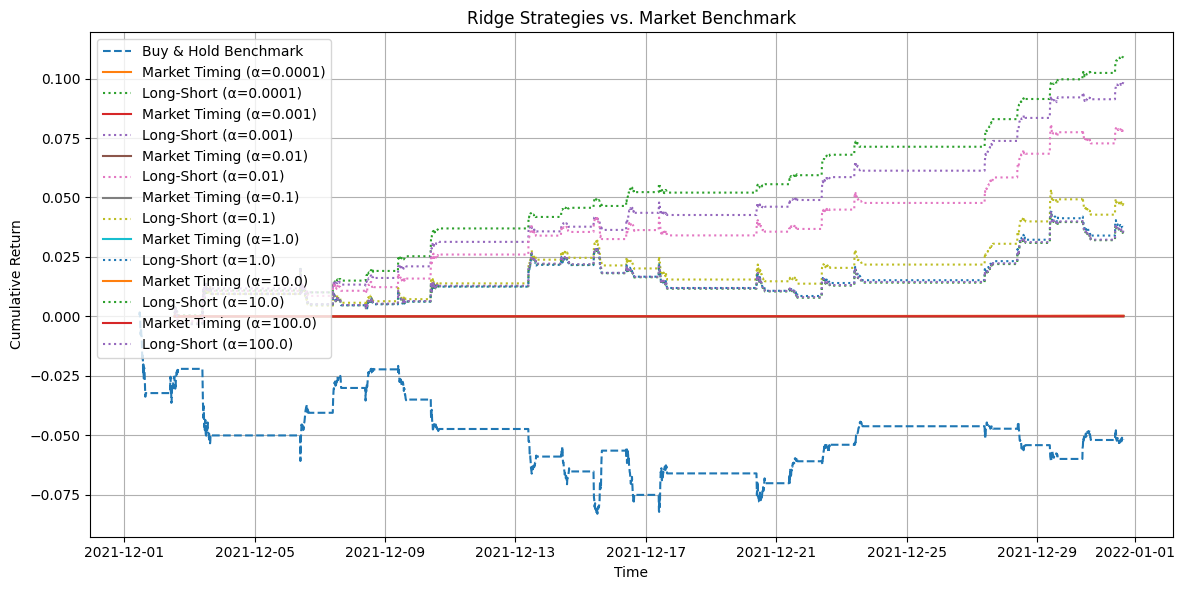

In [8]:
sys.argv = [
    'regressions.py',
    '--data_path', str(OUTPUT_PATH),
    '--model_path', '../../data/',
    '--model', 'ridge',
    '--shrinkage_list', *map(str, SHRINKAGE_LIST),
    '--plot', str(True)
]


strategies.main()